In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import io, signal, stats
import sys, os
sys.path.append('../')

import pandas as pd
from sklearn.decomposition import PCA
import fooof
from fooof import FOOOFGroup
from seaborn import despine

from galaxybrain.data_utils import load_mouse_data, return_pops

from neurodsp.spectral import compute_spectrum

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
matplotlib.rc('figure', max_open_warning = 0)

In [2]:
df_info = pd.read_csv("../data/df_info.csv", index_col = 0)

In [3]:
region_indices = {}
for region in df_info.region.unique():
    region_indices.update({region:np.where(df_info['region'] == str(region))[0]})

In [4]:
datafolder = '../../Neuropixel/'

su_start_ind = 10 #originally computed in spacerecon
df_spk = pd.read_csv("../data/df_spk.csv", index_col=0)

#set we are using 
rSPCA_d = df_spk[df_spk.columns[su_start_ind:]]
rSPCA_d.columns = rSPCA_d.columns.astype(int) #any way to do this automatically when loading csv?

In [5]:
th_subset = rSPCA_d[region_indices['TH']]
hpf_subset = rSPCA_d[region_indices['HPF']]

In [57]:
rSPCA_d

,0,1,2,3,4,5,6,7,8,9,...,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295
3310.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3312.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3313.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3314.0,2,10,8,0,3,5,7,1,0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531.0,0,0,0,0,0,0,0,0,0,0,...,8,2,0,6,3,4,8,8,0,0
5532.0,0,0,0,0,0,0,0,0,0,0,...,7,0,0,6,1,9,0,15,0,1
5533.0,0,0,0,0,0,0,0,0,0,0,...,9,2,0,2,2,5,2,10,0,0
5534.0,0,0,0,0,0,0,0,0,0,0,...,10,1,1,5,1,5,2,8,0,0


### Note:
everywhere "m" is in var declaration, that means slope/exponent

In [6]:
def FOOOFy(components, spectra, freq_range):
    fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False) #initialize FOOOF object
    
    #print(spectra.shape, components.shape) #Use this line if things go weird
    
    fg.fit(components, spectra, freq_range) # THIS IS WHERE YOU SAY WHICH FREQ RANGE TO FIT
    m_array = fg.get_params('aperiodic_params', 'exponent') 
    r2_array = fg.get_params('r_squared') #correlation between components (freqs or PCs) and spectra (powers or eigvals)
    #fg.r_squared_
    return m_array, r2_array

def PCAonData(subset, n_pc):
    pop_pca = PCA(n_pc).fit(subset)
    evals = pop_pca.explained_variance_ratio_
    
    return evals

def ftOnData(subset, fs, nperseg, noverlap):
    summed_neurons = subset.sum(axis= 1) # summing data for ft decomp.
    freqs, powers = compute_spectrum(summed_neurons, fs = fs, nperseg = nperseg, noverlap = noverlap)   #making these parameters now
    
    return freqs, powers

def random_subset_decomp(data, subset_size, n_iter, n_pc, pc_range, f_range, verbose = False):
    
    #Make these parameters for main func later
    fs=1; nperseg=200; noverlap=50
    
    freqs = np.fft.rfftfreq(nperseg) #added this
    
    evals_mat = np.zeros((n_iter, n_pc)) # n_iter * |evals|
    powers_mat = np.zeros((n_iter, len(freqs)))  
    
    for i in np.arange(n_iter):
        loc_array = np.random.choice(data.shape[1], subset_size)
        subset = data.iloc[:,loc_array]
        
        # decomposition in space
        evals = PCAonData(subset, n_pc)               
        evals_mat[i] = evals
        
        # decomposition in time
        freqs, powers = ftOnData(subset, fs, nperseg, noverlap)
        powers_mat[i] = powers
    
#     print('PCA')
    e_axis = np.arange(1,n_pc+1)
#     print(e_axis.shape, evals_mat.shape, pc_range)
    pca_m_array, pca_r2_array = FOOOFy(e_axis, evals_mat, pc_range) #space decomposition exponents, and r2
#     print('PSD')
    ft_m_array, ft_r2_array = FOOOFy(freqs, powers_mat, f_range) #time decomposition exponents, and r2
    
    if verbose == True:
        
        print('Avg Space Decomposition slope:', np.mean(pca_m_array))
        print('Avg Time Decomposition slope:', np.mean(ft_m_array))
    
        plt.figure()
        plt.hist(pca_m_array)
        plt.title('Space Decomp')
        #plt.title('n_subset = ', subset_size)
        plt.figure()
        plt.hist(ft_m_array)
        plt.title('Time Decomp')
        plt.plot()
    
    return evals_mat, pca_m_array, pca_r2_array, powers_mat, ft_m_array, ft_r2_array

In [ ]:
evs, ev_m, ev_r2, pows, pow_m, pow_r2 = randomSubsetDecomp(th_subset, 50, 100, n_pc = 40, verbose = True)

In [177]:
np.fft.rfftfreq(200)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  ])

### Note: 

- Dimensions of eigenvalues and powers: n_iter * # components (could be #freq or #PCs)

In [7]:
def Ramsey(data, subset_sizes, n_iters = 400, n_pc = None, pc_range = [0,None], f_range = [0,None], verbose = True): 
    n = len(subset_sizes)
    
    #size = np.arange(0,n)
    eigs = np.zeros((n_iters, n)) #right dims?
    pows = np.zeros((n_iters, n))
    
    pca_m = np.zeros((n_iters, n)) # dims: n_iters * amount of subset sizes
    ft_m = np.zeros((n_iters, n))
    
    space_r2 = np.zeros((n_iters, n))
    time_r2 = np.zeros((n_iters, n))
    
    pearson_r = np.zeros(n)
    pearson_p = np.zeros(n)
    spearman_rho = np.zeros(n)
    spearman_p = np.zeros(n)
    
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.inferno(np.linspace(0,1,n)))
    
    for i, n_i in enumerate(subset_sizes):
        
        #if at some subset size not enough pc's, default to biggest
        #default is using a proportion of that 
        
        if n_pc == None: #does this still need to be None?  Will it ever be manually changed?
            n_pc_curr = min(subset_sizes)
        
        elif type(n_pc) == int and n_pc < n_i:
            n_pc_curr = n_pc
            
        elif type(n_pc) == float:
            n_pc_curr = int(n_pc*n_i)
            
        #write conditions for pc_range,  use a function, or outside of this
        # [0,None] for whole range, otherwise check if float for fraction
        
        if type(pc_range[1]) == float: #if second element of pc_range is float, it is a percentage of pc's
            pc_frac = pc_range[1]
            curr_pc_range = [pc_range[0],int(n_pc_curr*pc_frac)]
              
        elif pc_range[1] == None:
            curr_pc_range = None
            
        else:
            curr_pc_range = pc_range
            
        #f_range conditions 
        if type(f_range[1]) == float:
            curr_f_range = [f_range[0],f_range[1]]
        
        elif f_range[1] == None:
            curr_f_range = None
        
        
        evs, ev_m, ev_r2, pows, pow_m, pow_r2 = random_subset_decomp(data, n_i, n_iters, n_pc_curr , pc_range = curr_pc_range, f_range = curr_f_range) #remember to add parameters later, check function doc for output
        
        #eigs[:,i] = np.mean(evs, axis=0)
        #pows[:,i] = np.mean(pows, axis=0)
        
        pca_m[:,i] = ev_m
        ft_m[:,i] = pow_m
        
        space_r2[:,i] = ev_r2
        time_r2[:,i] = pow_r2
        
        #This is where you'd start resampling (iteratively)
        pearson_r[i], pearson_p[i] = stats.pearsonr(ev_m, pow_m)
        spearman_rho[i], spearman_p[i] = stats.spearmanr(ev_m, pow_m)
        
        if verbose == True:
            
            if i == 0: #only creates figure for the first iter, then it just plots over
                plt.figure(figsize=(10,5))
            
            # plot eigenspectrum
            plt.subplot(1,2,1)
            #plt.loglog(np.arange(1,n_pc+1), evs.T, 'k', lw=1, alpha=0.2)
            #plt.loglog(np.arange(1,n_pc+1), evs.mean(0), 'r')
            plt.errorbar(np.arange(1,n_pc_curr+1), evs.mean(0), evs.std(0))
            plt.yscale('log'); plt.xscale('log');
            
            #plot powerspectrum
            plt.subplot(1,2,2)
            #plt.loglog(np.arange(0,0.505,0.005), pows.T, 'k', lw=1, alpha=0.2)
            #plt.loglog(np.arange(0,0.505,0.005), pows.mean(0), 'r')
            plt.errorbar(np.arange(0,0.505,0.005), pows.mean(0), pows.std(0))
            plt.yscale('log'); plt.xscale('log');
        
    return pca_m, space_r2, ft_m, time_r2, pearson_r, spearman_rho, pearson_p, spearman_p


In [ ]:
subsetsizes = np.arange(20,100,15)
pcm, s_r2, ftm, t_r2, pr, sr, pp, sp = Ramsey(th_subset, subsetsizes, n_iters = 10, n_pc = 0.7)

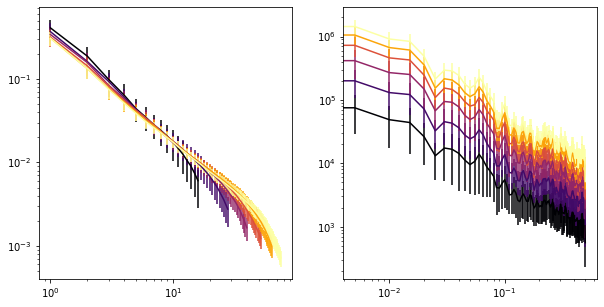

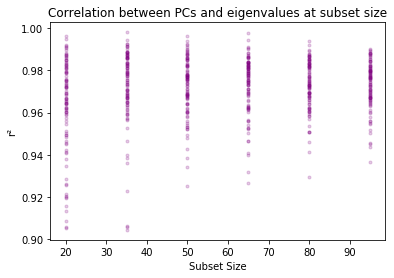

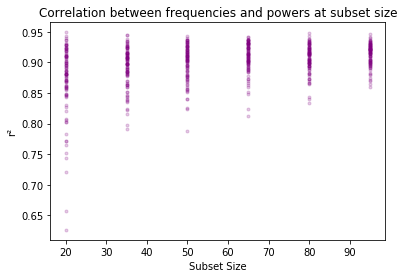

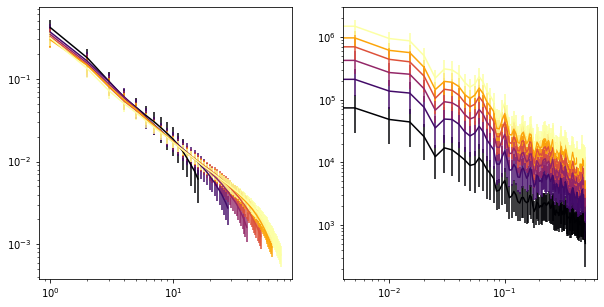

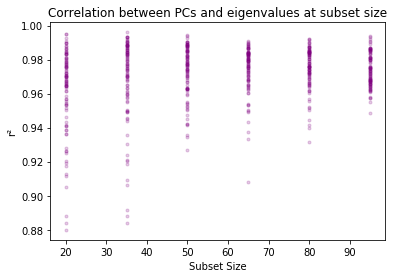

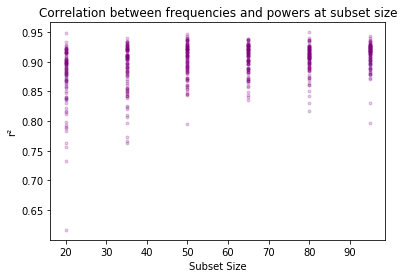

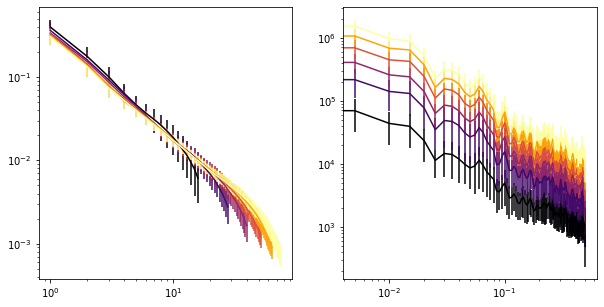

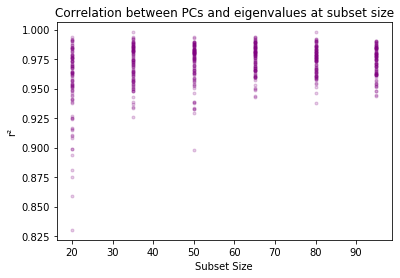

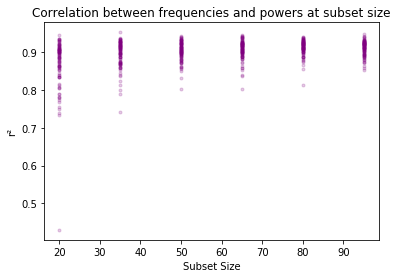

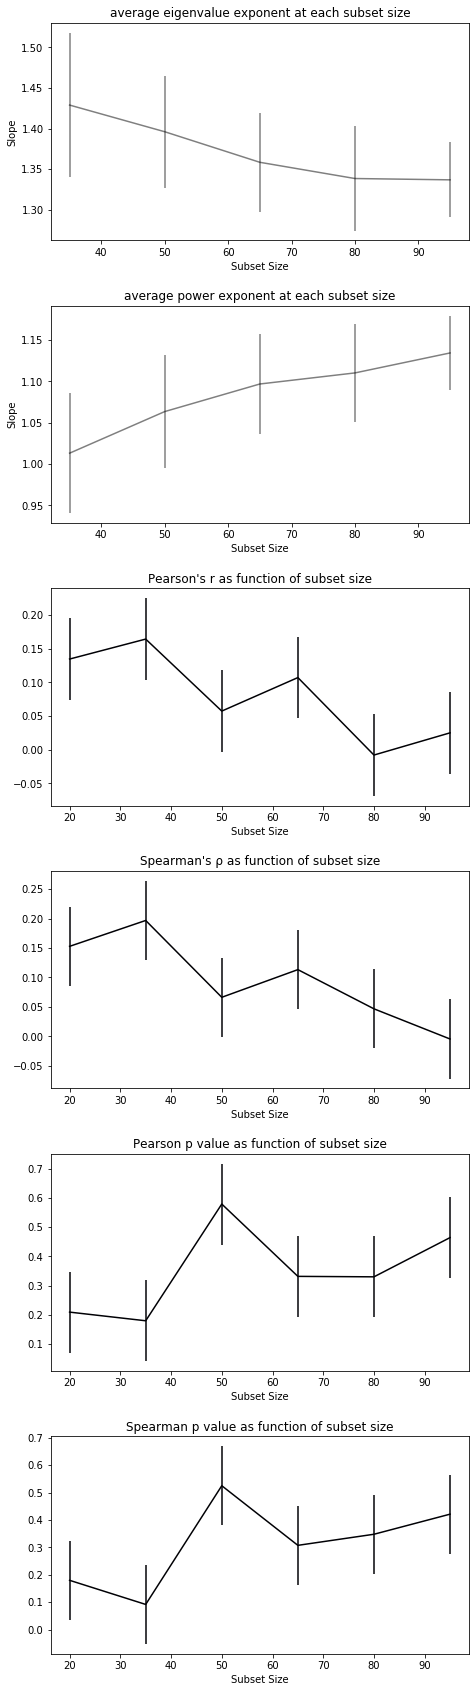

In [51]:
subsetsizes = np.arange(20,100,15)
decomp_array = []
for i in range(3):
    pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = Ramsey(th_subset, subsetsizes, n_iters = 100, n_pc = 0.8, f_range=[0,0.4])
    decomp_array.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])
    plot_comp_spectra_corr(subsetsizes,s_r2, t_r2)
#     np.savez('LOC'+str(i+1), pca_m=pca_m, space_r2=s_r2, ft_m=ft_m, time_r2=t_r2, pearson_r=psn_r, spearman_rho=spn_r, pearson_p=psn_p, spearman_p=spn_p)

decomp_array= np.array(decomp_array)
plot_decomp_features(subsetsizes, decomp_array[:,0].mean(0), decomp_array[:,1].mean(0), decomp_array[:,2].mean(0), decomp_array[:,3].mean(0), decomp_array[:,4].mean(0), decomp_array[:,5].mean(0))

In [54]:
decomp_array.shape

(3, 6)

In [53]:
type(decomp_array[0][0])

numpy.ndarray

In [8]:
def plot_comp_spectra_corr(subsetsizes, space_r2, time_r2):
    """
    Correlation between components and spectra w/ subset size
    """
    plt.figure()
    plt.plot(subsetsizes[:], space_r2.T[:], ".", color = 'purple', lw=1, alpha=0.2)
    plt.title('Correlation between PCs and eigenvalues at subset size')
    plt.xlabel('Subset Size')
    plt.ylabel('r\u00b2')
    plt.figure()
    plt.plot(subsetsizes[:], time_r2.T[:],  ".", color = 'purple', lw=1, alpha=0.2)
    plt.title('Correlation between frequencies and powers at subset size')
    plt.xlabel('Subset Size')
    plt.ylabel('r\u00b2')

In [ ]:
plot_comp_spectra_corr(subsetsizes,s_r2, t_r2)

In [50]:
def plot_decomp_features(subsetsizes, space_slopes, time_slopes, pearson_corr, spearman_corr, pearson_p, spearman_p, trial_i = 0):
    
    if trial_i == 0: #only creates figure for the first iter, then it just plots over
        plt.figure(figsize=(7.5, 30))
 
    #Avg decomp. slope @ subset size
    plt.subplot(6,1,1)
    plt.errorbar(subsetsizes[1:], space_slopes.mean(0)[1:], space_slopes.std(0)[1:], color = 'black', alpha = 0.5)
    plt.title('average eigenvalue exponent at each subset size')
    plt.xlabel('Subset Size')
    plt.ylabel('Slope')
    
    plt.subplot(6,1,2)
    plt.errorbar(subsetsizes[1:], time_slopes.mean(0)[1:], time_slopes.std(0)[1:], color = 'black', alpha = 0.5)
    plt.title('average power exponent at each subset size')
    plt.xlabel('Subset Size')
    plt.ylabel('Slope')

    #Pearson (R) Correlation value as function of subset size
    plt.subplot(6,1,3)
    plt.errorbar(subsetsizes, pearson_corr, pearson_corr.std(0), color = 'blue', alpha = 0.5)
    #plt.plot(subsetsizes, pearson_corr, color = 'blue', alpha = 0.5)
    plt.title('Pearson\'s r as function of subset size')
    plt.xlabel('Subset Size')
    
    #Spearman (Rho) Correlation value as function of subset size
    plt.subplot(6,1,4)
    plt.errorbar(subsetsizes, spearman_corr, spearman_corr.std(0), color = 'blue', alpha = 0.5)
    #plt.plot(subsetsizes, spearman_corr, color = 'blue', alpha = 0.5)
    plt.title('Spearman\'s ρ as function of subset size')
    plt.xlabel('Subset Size')

    #Pearson p values
    plt.subplot(6,1,5)
    plt.errorbar(subsetsizes, pearson_p, pearson_p.std(0), color = 'green', alpha = 0.5)
    #plt.semilogy(subsetsizes, pearson_p, color = 'green', alpha = 0.5)
    plt.title('Pearson p value as function of subset size')
    plt.xlabel('Subset Size')
    
    #Spearman p values
    plt.subplot(6,1,6)
    plt.errorbar(subsetsizes, spearman_p, spearman_p.std(0), color = 'green', alpha = 0.5)
    #plt.semilogy(subsetsizes, spearman_p, color = 'green', alpha = 0.5)
    plt.title('Spearman p value as function of subset size')
    plt.xlabel('Subset Size')
    
    plt.subplots_adjust(hspace=.3)


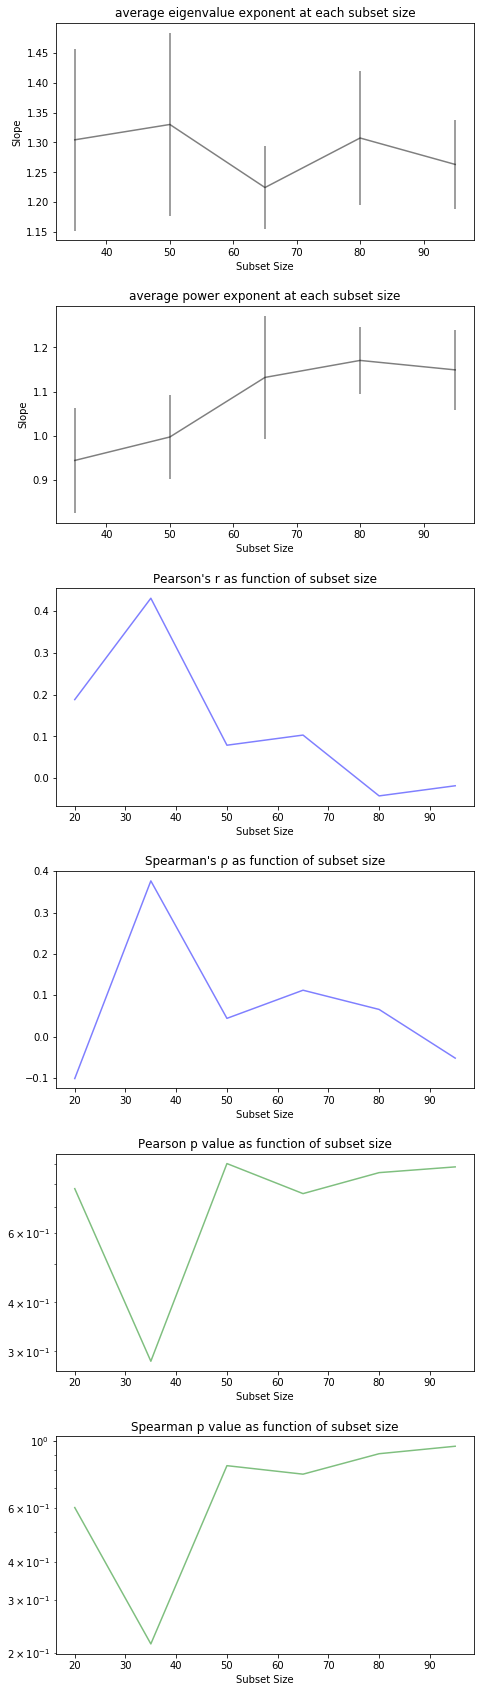

In [172]:
#why are prints statements returned all at once?
plot_decomp_features(subsetsizes, pcm, ftm, sr, pr, pp, sp,trial_i=0)

- scatter of eigs and powers arrays: scatter at each subset size 
- avg value at each subset size (for both space and time)
        - at each subset size to the slopes stay the same?

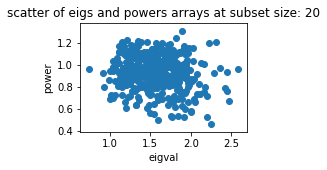

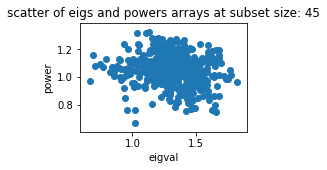

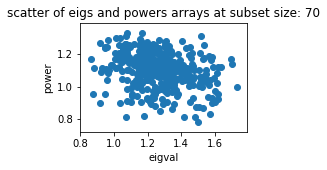

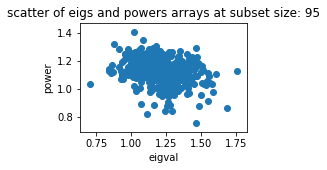

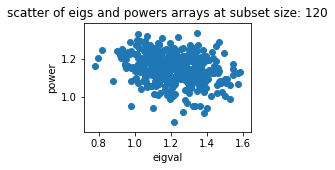

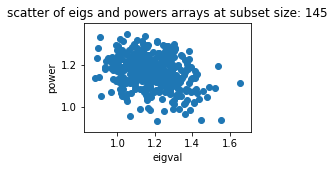

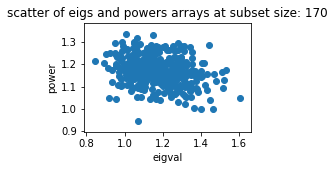

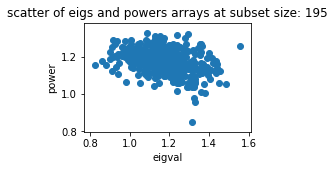

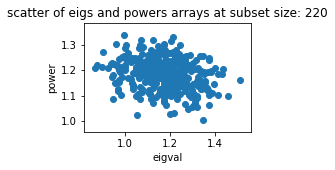

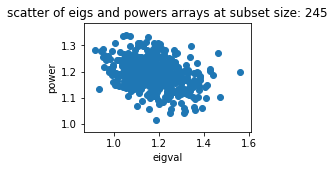

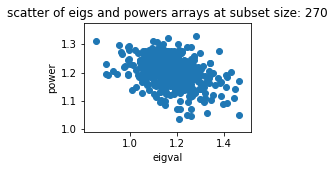

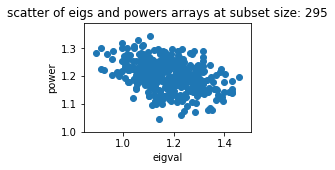

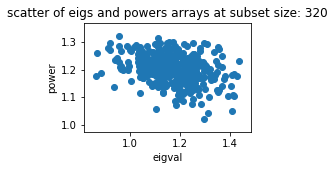

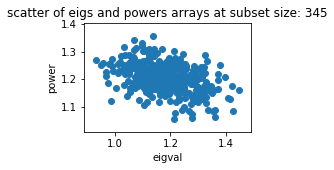

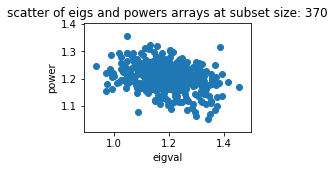

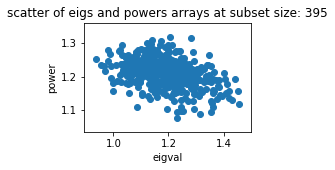

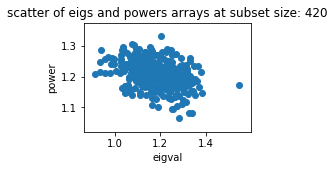

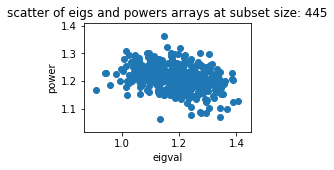

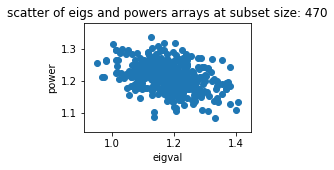

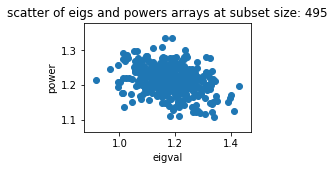

In [33]:
for i, n_i in enumerate(subsetsizes):
    plt.figure(figsize=(3,2))
    plt.scatter(pcm[:,i], ftm[:,i])
    plt.xlabel('eigval')
    plt.ylabel('power')
    plt.title('scatter of eigs and powers arrays at subset size: ' + str(n_i))

Text(0.5, 1.0, 'avg power exponent at each subset size')

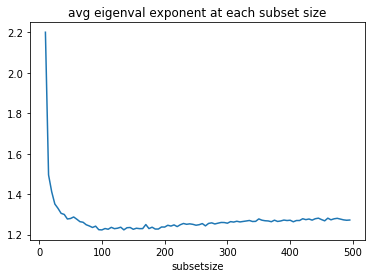

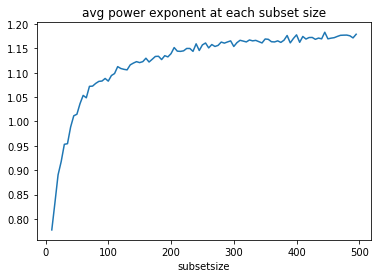

In [95]:
plt.figure()
plt.plot(subsetsizes, me)
plt.xlabel('subsetsize')
plt.title('avg eigenval exponent at each subset size')
plt.figure()
plt.plot(subsetsizes, mp)
plt.xlabel('subsetsize')
plt.title('avg power exponent at each subset size')

________________________

# Testing Grounds

~~~~~~~~~~~~~~~~~~~~~

original pca decomp func

In [ ]:
rSPCA_d = df_spk[df_spk.columns[su_start_ind:]] #set we are using

def randomSubsetPCA(data, subset_size, n_iter, n_pc = None):
    if n_pc == None:
        n_pc = subset_size
        

    evals_mat = np.zeros((n_iter, n_pc)) # n_iter * |evals|
    
    
    for i in np.arange(n_iter):
        loc_array = np.random.choice(data.shape[1], subset_size)
        subset = data[loc_array]
        
        # decomposition in space
        
        pop_pca = PCA(n_pc).fit(subset)
        evals = pop_pca.explained_variance_ratio_                
        evals_mat[i] = evals
        
      
    
    
    #PCA FOOOF
    
    fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed')
    fg.fit(np.arange(1,n_pc+1), evals_mat)
    m_array=fg.get_params('aperiodic_params', 'exponent')
        

    
    print('Avg slope:', np.mean(m_array))
    plt.hist(m_array)
#    plt.title('n_subset = ', subset_size)
#    plt.plot()
    return evals_mat, m_array

In [ ]:
evals, slopes = randomSubsetPCA(rSPCA_d, 100, 200, n_pc = 30)

--Power spectrum stuff--

In [ ]:
sn = rSPCA_d.sum(axis= 1) # copying df for ft decomp.
freqs, powers = compute_spectrum(sn, fs=1, nperseg=200, noverlap=50)

# fs = 1000
# freqs = np.fft.fftfreq(len(sn),1/fs)

# fft = np.fft.fft(sn/fs)
# powers = np.abs(fft)
plt.plot(freqs, powers)
plt.xlabel('Frequencies (Hz)');plt.ylabel('Power (V^2)');
plt.xlim([-1,100])
plt.figure()
plt.loglog(freqs, powers)
plt.xlabel('log Frequencies (Hz)');plt.ylabel('log Power (V^2)');

In [ ]:
f, t, Sxx = signal.spectrogram(sn, 1000)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,100])
plt.show()

# Past Saves

#### SubsetDecomp

In [ ]:
#A FOOOF Function, gets exponent parameters
def FOOOFy(components, spectra, freq_range):
    fg = FOOOFGroup(max_n_peaks=0, aperiodic_mode='fixed', verbose = False) #initialize FOOOF object
    
    #print(spectra.shape, components.shape) #Use this line if things go weird
    
    fg.fit(components, spectra, freq_range) # THIS IS WHERE YOU SAY WHICH FREQ RANGE TO FIT
    m_array = fg.get_params('aperiodic_params', 'exponent') 
    r2_array = fg.get_params('r_squared') #correlation between components (freqs or PCs) and spectra (powers or eigvals)
    #fg.r_squared_
    return m_array, r2_array

#Decomposition in space
def PCAonData(subset, n_pc):
    pop_pca = PCA(n_pc).fit(subset)
    evals = pop_pca.explained_variance_ratio_
    
    return evals

#Decomposition in time
def ftOnData(subset, fs, nperseg, noverlap):
    summed_neurons = subset.sum(axis= 1) # summing data for ft decomp.
    freqs, powers = compute_spectrum(summed_neurons, fs = fs, nperseg = nperseg, noverlap = noverlap)   #making these parameters now
    
    return freqs, powers

def randomSubsetDecomp(data, subset_size, n_iter, n_pc = None, verbose = False, pc_range, f_range):
    if n_pc == None:
        n_pc = subset_size
    
    #Make these parameters for main func later
    fs=1; nperseg=200; noverlap=50
    
    freqs = np.fft.rfftfreq(nperseg) #added this
    
    evals_mat = np.zeros((n_iter, n_pc)) # n_iter * |evals|
    powers_mat = np.zeros((n_iter, len(freqs)))  
    
    for i in np.arange(n_iter):
        loc_array = np.random.choice(data.shape[1], subset_size)
        subset = data[loc_array]
        
        # decomposition in space
        evals = PCAonData(subset, n_pc)               
        evals_mat[i] = evals
        
        # decomposition in time
        freqs, powers = ftOnData(subset, fs, nperseg, noverlap)
        powers_mat[i] = powers
        
    pca_m_array, pca_r2_array = FOOOFy(np.arange(1,n_pc+1), evals_mat, pc_range) #space decomposition exponents, and r2
    ft_m_array, ft_r2_array = FOOOFy(freqs, powers_mat, f_range) #time decomposition exponents, and r2
    
    if verbose == True:
        
        print('Avg Space Decomposition slope:', np.mean(pca_m_array))
        print('Avg Time Decomposition slope:', np.mean(ft_m_array))
    
        plt.figure()
        plt.hist(pca_m_array)
        plt.title('Space Decomp')
        #plt.title('n_subset = ', subset_size)
        plt.figure()
        plt.hist(ft_m_array)
        plt.title('Time Decomp')
        plt.plot()
    
    
    return evals_mat, pca_m_array, pca_r2_array, powers_mat, ft_m_array, ft_r2_array #, freqs_mat

#### Ramsey

In [ ]:
def Ramsey(data, subset_sizes, n_iters = 400, n_pc = None): 
    n = len(subset_sizes)
    
    if n_pc == None:
        n_pc = min(subset_sizes)
    
    #size = np.arange(0,n)
    eigs = np.zeros((n_iters, n))
    powers = np.zeros((n_iters, n))
    
    avg_eig = np.zeros(n) 
    avg_pow = np.zeros(n)
    
    corr_coeffs = np.zeros(n) #del later: just changed from (1, n) to n  
    
    for i, n_i in enumerate(subset_sizes):
        
        pc, µp, ft, µf = randomSubsetDecomp(data, n_i, n_iters, n_pc) #remember to add parameters later
        
        eigs[:,i] = pc
        powers[:,i] = ft
        
        avg_eig[i] = µp
        avg_pow[i] = µf
        
        corr_coeffs[i] = np.corrcoef(pc,ft)[0][1] #removed [0] 
        
        # plot eigenspectrum
        # plot correlation for each fraction of dataset
        
    return eigs, powers, avg_eig, avg_pow, corr_coeffs

#### udpated ramsey

In [ ]:
def Ramsey(data, subset_sizes, n_iters = 400, n_pc = None, verbose = True, pc_range = None, f_range = None): 
    n = len(subset_sizes)
    
    if n_pc == None:
        n_pc = min(subset_sizes)
    
    #size = np.arange(0,n)
    eigs = np.zeros((n_iters, n)) #right dims?
    pows = np.zeros((n_iters, n))
    
    pca_m = np.zeros((n_iters, n)) # dims: n_iters * amount of subset sizes
    ft_m = np.zeros((n_iters, n))
    
    space_r2 = np.zeros((n_iters, n))
    time_r2 = np.zeros((n_iters, n))
    
    
    corr_coeffs = np.zeros(n) #del later: just changed from (1, n) to n  
    
    for i, n_i in enumerate(subset_sizes):
        
        evs, ev_m, ev_r2, pows, pow_m, pow_r2 = randomSubsetDecomp(data, n_i, n_iters, n_pc, pc_range, f_range) #remember to add parameters later, check function doc for output
        
        #eigs[:,i] = np.mean(evs, axis=0)
        #pows[:,i] = np.mean(pows, axis=0)
        
        pca_m[:,i] = ev_m
        ft_m[:,i] = pow_m
        
        space_r2[:,i] = ev_r2
        time_r2[:,i] = pow_r2
        
        corr_coeffs[i] = np.corrcoef(ev_m,pow_m)[0][1] #removed [0] 
        
        if verbose == True:
            # plot eigenspectrum
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.loglog(np.arange(1,n_pc+1), evs.T, 'k', lw=1, alpha=0.2)
            plt.loglog(np.arange(1,n_pc+1), evs.mean(0), 'r')
        
            #plot powerspectrum
            plt.subplot(1,2,2)
            plt.loglog(np.arange(0,0.505,0.005), pows.T, 'k', lw=1, alpha=0.2)
            plt.loglog(np.arange(0,0.505,0.005), pows.mean(0), 'r')
        
    return pca_m, space_r2, ft_m, time_r2, corr_coeffs
